In [5]:
import numpy as np
import tensorflow as tf
import io
import binvox_rw
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, Conv3DTranspose, Concatenate
from tensorflow.keras.layers import MaxPool2D, UpSampling3D, Reshape
from tensorflow.keras.models import Sequential, Model
import zipfile
import os

In [2]:
class voxel_gen(Sequence):
    def __init__(self, x_set, batch_size=32, dim=(128,128,128)):
        self.x = x_set # path for each dataset : models/models-binvox-solid
        self.batch_size = batch_size
        self.dim = dim

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x_set_temp = self.x[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(x_set_temp)
        return X
    
    def __data_generation(self, x_set_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, 1))

        for i, x_set in enumerate(x_set_temp):
            # Store sample
            with open(str(x_set), 'rb') as f:
                model = binvox_rw.read_as_3d_array(f)
            X[i,] = np.expand_dims(model.data, axis=-1)
        return X

In [3]:
def customGen(batch_size=32):
    gen = ImageDataGenerator(rescale=1/255.)
    view0 = gen.flow_from_directory(
        "models/models-screenshots/view0",
        target_size=(512, 512),
        shuffle=False,
        batch_size=batch_size,
        class_mode=None)

    view1 = gen.flow_from_directory(
        "models/models-screenshots/view1",
        target_size=(512, 512),
        shuffle=False,
        batch_size=batch_size,
        class_mode=None)

    view2 = gen.flow_from_directory(
        "models/models-screenshots/view2",
        target_size=(512, 512),
        shuffle=False,
        batch_size=batch_size,
        class_mode=None)

    view3 = gen.flow_from_directory(
        "models/models-screenshots/view3",
        target_size=(512, 512),
        shuffle=False,
        batch_size=batch_size,
        class_mode=None)
    
    voxels = Path("models/models-binvox-solid/data")
    fvoxels = [f for f in voxels.iterdir() if f.is_file()]
    
    out = voxel_gen(fvoxels, batch_size)
    while True:
        for x1, x2, x3, x4, y in zip(view0, view1, view2, view3, out):
            yield [x1,x2,x3,x4], y

Found 11694 images belonging to 1 classes.
Found 11694 images belonging to 1 classes.
Found 11694 images belonging to 1 classes.
Found 11694 images belonging to 1 classes.
100f39dce7690f59efb94709f30ce0d2


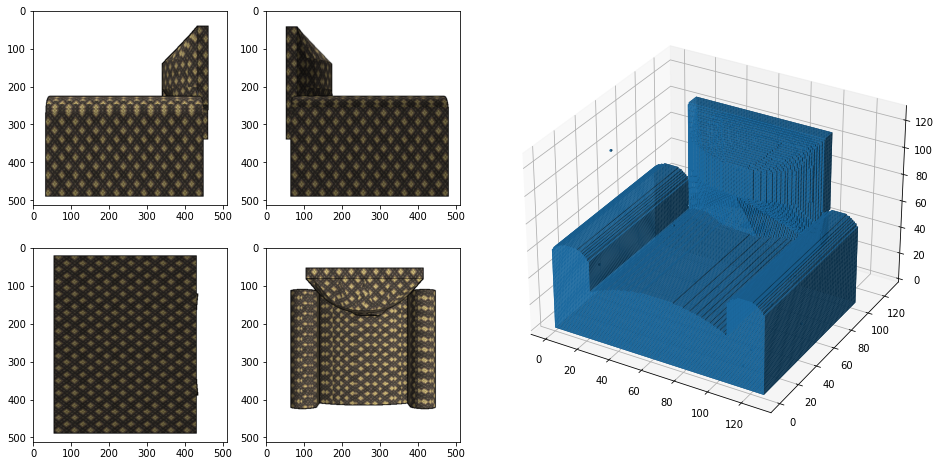

101354f9d8dede686f7b08d9de913afe


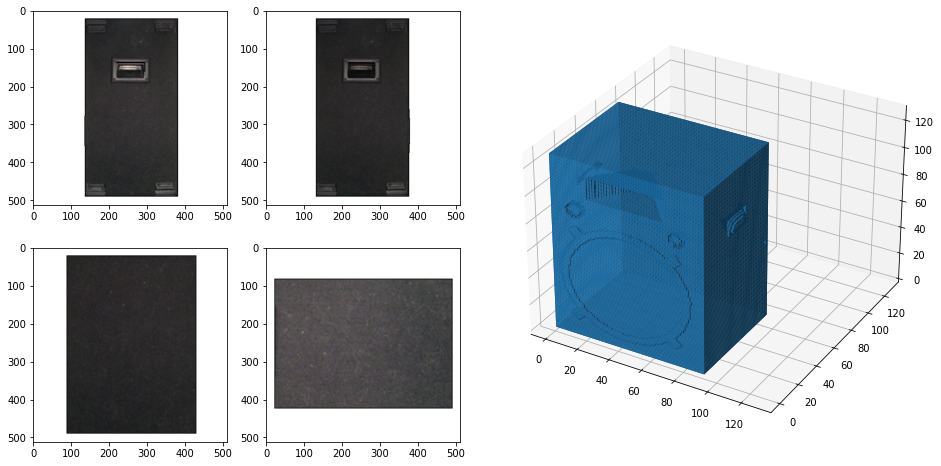

1018f01d42ae7fad52249d8432f6087e


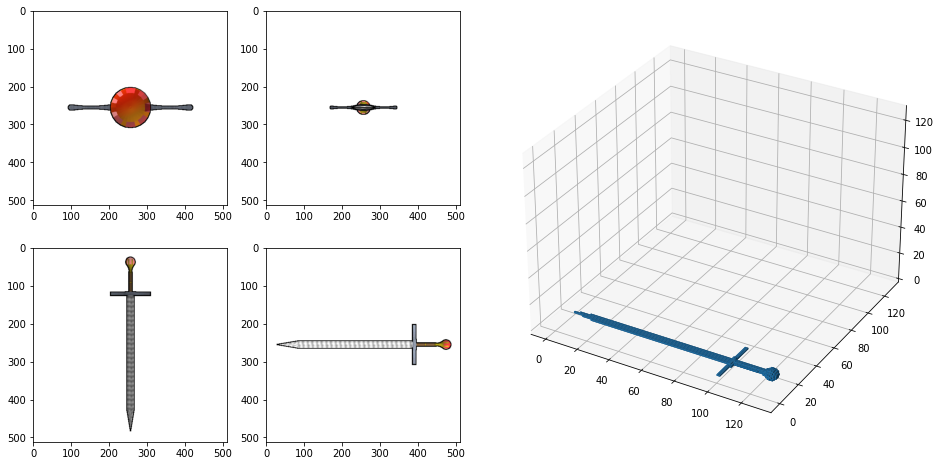

102273fdf8d1b90041fbc1e2da054acb


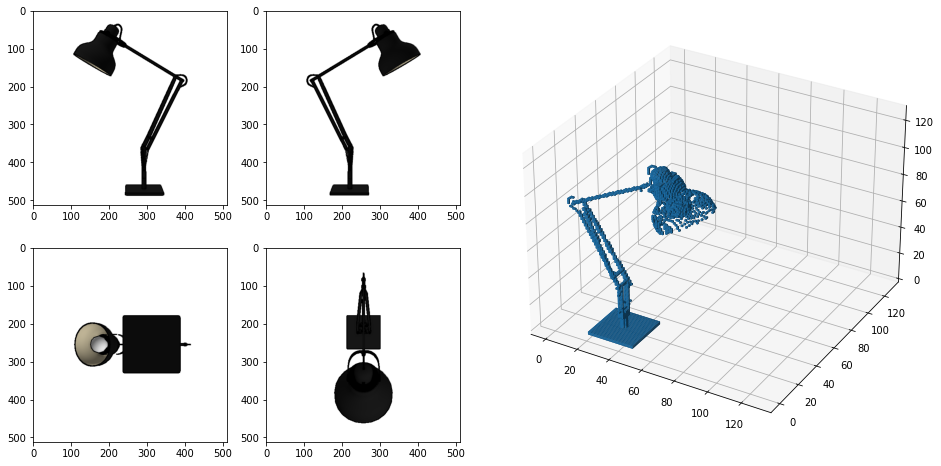

In [4]:
gen1 = customGen(1)
voxels=Path("models/models-binvox-solid/data")
fvoxels=[f for f in voxels.iterdir() if f.is_file()]
count = -1
for X, y in gen1:
    count += 1
    if count<4:
        print(fvoxels[count].stem)
        fig = plt.figure(figsize=(16, 8))
        ax1 = plt.subplot2grid((2, 4), (0, 0))
        ax2 = plt.subplot2grid((2, 4), (0, 1))
        ax3 = plt.subplot2grid((2, 4), (1, 0))
        ax4 = plt.subplot2grid((2, 4), (1, 1))
        ax5 = plt.subplot2grid((2, 4), (0, 2), colspan=2, rowspan=2, projection='3d')
        ax1.imshow(np.squeeze(X[0]))
        ax2.imshow(np.squeeze(X[1]))
        ax3.imshow(np.squeeze(X[2]))
        ax4.imshow(np.squeeze(X[3]))
        ax5.voxels(np.squeeze(y))
        plt.show()
    else:
        break

In [ ]:
def encode_decode():
    inview0 = Input(shape=(512, 512, 3), name='view0')
    inview1 = Input(shape=(512, 512, 3), name='view1')
    inview2 = Input(shape=(512, 512, 3), name='view2')
    inview3 = Input(shape=(512, 512, 3), name='view3')
    
    encoder = Sequential([
            Conv2D(32, 7, (2, 2), activation='relu'),
            MaxPool2D((2, 2)),
            Conv2D(32, 5, activation='relu'),
            MaxPool2D((2, 2)),
            Conv2D(64, 3, activation='relu'),
            MaxPool2D((2, 2)),
            Conv2D(64, 3, activation='relu'),
            MaxPool2D((2, 2)),
            Conv2D(128, 3, activation='relu'),
            MaxPool2D((2, 2)),
            Conv2D(32, 5, activation='relu'),
            Reshape((1, 1, 1, -1))
    ], name='encoder')
    
    combined = Concatenate(axis=4)([encoder(inview0), encoder(inview1), encoder(inview2), encoder(inview3)])
    
    decoder = Sequential([
            Conv3DTranspose(128, 3, activation='relu'),
            UpSampling3D(2),
            Conv3DTranspose(64, 3, activation='relu'),
            UpSampling3D(2),
            Conv3DTranspose(32, 3, activation='relu', padding='same'),
            UpSampling3D(2),
            Conv3DTranspose(16, 3, activation='relu', padding='same'),
            UpSampling3D(2),
            Conv3DTranspose(8, 3, activation='relu', padding='same'),
            UpSampling3D(2)
    ], name='decoder')(combined)
    
    out = Conv3DTranspose(1, 3, activation='sigmoid', padding='same')(decoder)
    
    return Model(inputs=[inview0, inview1, inview2, inview3], outputs=out)

In [ ]:
tf.keras.backend.clear_session()
model = encode_decode()
model.summary(line_length=118, positions=[.38, .66, .75, 1.], expand_nested=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
model.compile(optimizer, loss)

In [ ]:
model.fit(customGen(batch_size=4),epochs=10, batch_size=4, steps_per_epoch=tf.math.ceil(11694/4))

In [6]:
with open(Path("C:/Users/prade/Desktop/project/MeshToBinvox-master/MeshToBinvox-master/vox.binvox"),"rb") as f:
    model = binvox_rw.read_as_3d_array(f)
fig = plt.figure(figsize=(16, 8))  
ax.voxels(np.squeeze(model.data))   

ValueError: cannot reshape array of size 12759516 into shape (256,256,256)

In [9]:
(12759516)**(1/3)




233.67454206919416